In [4]:
!pip install tensornetwork

In [5]:
import matplotlib.pyplot as plt
import logging
import numpy as np
import math
import tensornetwork as tn
from albumentations.augmentations.crops.transforms import CenterCrop
import logging
from pgm import create_node
from pgm import create_node_from_pgm
from pgm import crop_pgm_image
from ipywidgets import interact

ModuleNotFoundError: No module named 'pgm'

In [ ]:
file_l = ['nightshot_iso_100.pgm']

def getInitialMatrix():
  for file_name in file_l:
    with open(file_name, 'rb') as pgmf:
      im = plt.imread(pgmf)
      img = crop_pgm_image(im)
      A = np.array(img)
      R = A>0.5
      R[R == True] = 1 
      R[R == False] = 0
      R = R.astype(np.float64, copy=False)

      return A, R

def ALS(A, R, n_factors, n_iterations, lambda_):
    '''
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    '''
    #print("Initiating ")
    # lambda_ = 0.1; n_factors = 30; n, m = A.shape; n_iterations = 10
    n, m = A.shape;
    Users = 5 * np.random.rand(n, n_factors)
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    # MSE_List = []

    #print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(np.dot(Items, np.dot(np.diag(Ri), Items.T)) + lambda_ * np.eye(n_factors),
                                       np.dot(Items, np.dot(np.diag(Ri), A[i].T))).T
        #print("Error after solving for User Matrix:", get_error(A, Users, Items, R))

        for j, Rj in enumerate(R.T):
            Items[:,j] = np.linalg.solve(np.dot(Users.T, np.dot(np.diag(Rj), Users)) + lambda_ * np.eye(n_factors),
                                     np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])))
        #print("Error after solving for Item Matrix:", get_error(A, Users, Items, R))

        # MSE_List.append(get_error(A, Users, Items, R))
        #print('%sth iteration is complete...' % iter)

    #print(MSE_List)
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    # plt.title('Python Implementation MSE by Iteration \n with %d users and %d movies' % A.shape);
    # plt.show()


    return Users, Items

def loss(original, reconst):
    n, m = original.shape
    return np.sum((reconst - original)**2) / (n * m)

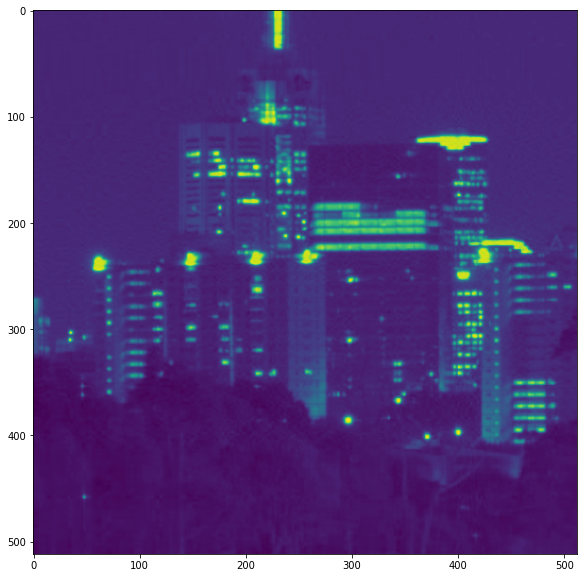

In [ ]:
A, R = getInitialMatrix()
Users, Items = ALS(A, R, n_factors = 75, n_iterations = 10, lambda_ = .1)
matrix = Users @ Items
fig = plt.figure(figsize=(32, 10))
ax = fig.add_subplot(121)
plt.imshow(matrix)

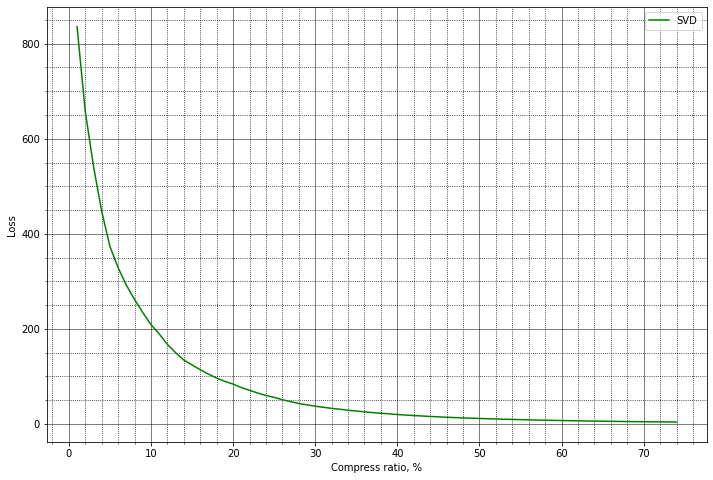

In [ ]:
file_l = ['nightshot_iso_100.pgm']
for file_name in file_l:
    with open(file_name, 'rb') as pgmf:
      im = plt.imread(pgmf)
      img = crop_pgm_image(im)
A, R = getInitialMatrix()
loss_list = []
for i in range(1,75):
  Users, Items = ALS(A, R, n_factors = i, n_iterations = 10, lambda_ = .1)
  matrix = Users @ Items
  loss_list.append(loss(img, matrix))


compress_ratio = [x for x in range(1,75)]
fig = plt.figure(figsize=(26, 8))
ax = fig.add_subplot(121)
ax.minorticks_on()
ax.grid(which='major',
            color = 'k', 
            linewidth = 0.5)
ax.grid(which='minor', 
            color = 'k', 
            linestyle = ':')
plt.plot(compress_ratio, loss_list, c='green', label='SVD')
plt.ylabel('Loss')
plt.xlabel('Compress ratio, %')
plt.legend(loc='best')
#plt.title(f'{img_name}', loc='center')
plt.show()
  

---

## ALS for TN

In [11]:
import matplotlib.pyplot as plt
import logging
import numpy as np
import math
import tensornetwork as tn
from albumentations.augmentations.crops.transforms import CenterCrop
import logging
from pgm import create_node
from pgm import create_node_from_pgm
from pgm import crop_pgm_image
from ipywidgets import interact
import torch
import torch.nn as nn
import copy

In [15]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 

In [16]:
print(device)

cuda:0


In [17]:
tn.set_default_backend("pytorch")

In [18]:
def make_tensor(nodes_list):
  c = nodes_list[0]   \
      @ nodes_list[1] \
      @ nodes_list[2] \
      @ nodes_list[3] \
      @ nodes_list[4] \
      @ nodes_list[5] \
      @ nodes_list[6] \
      @ nodes_list[7]
  make_edges(nodes_list)
  return c.tensor.to(device)
    
def init_nodes(k=8):
  nodes_list = list()

  with tn.NodeCollection(nodes_list):
    for i in range(k):
      a = tn.Node(nn.Parameter(torch.rand([1 + 3 * (i == m) for m in range(k)], dtype=torch.float64).to(device), requires_grad=False))
  
  make_edges(nodes_list)
  
  return nodes_list


def make_edges(nodes_list, k=8):    
  for i in range(k):
    for j in range(i + 1, k):
      if i != j:
        nodes_list[i][j] ^ nodes_list[j][i]


def loss_fn(X, nodes_list):
  Y = make_tensor(nodes_list)
  loss_func = nn.MSELoss()
  return loss_func(X, Y)


def fit(X, l, num_ep=100, k=8):
    optimizer = torch.optim.Adam([l[i].tensor.to(device) for i in range(k)], lr=0.01)
    optimizer = optimizer
    for node in l:
        node.tensor.requires_grad = True
        for ep in range(num_ep):
            optimizer.zero_grad()
            loss = loss_fn(X, l)
            loss.backward()
            optimizer.step()
        node.tensor.requires_grad = False


def modify_node(node_tensor , index):
    z = list(node_tensor.shape)
    z[index] = 1
    prom = torch.rand(z, dtype=torch.float64).to(device)
    tensor = torch.cat((node_tensor, prom), index)
    return nn.Parameter(tensor, requires_grad= True).to(device)


def find_best_edge_and_modify_tn(X, nodes_list, num_iter_ep=30, num_itog_ep=100, k=8):
  loss = loss_fn(X, nodes_list)
  best_i_j = (-1,-1)
  for i in range(k):
    for j in range(i+1,k):
      # print(i,j)
      new_nodes_list = copy.deepcopy(nodes_list)

      new_nodes_list[i].tensor = modify_node(new_nodes_list[i].tensor, j)
      new_nodes_list[j].tensor = modify_node(new_nodes_list[j].tensor, i)
      
      fit(X, new_nodes_list, num_iter_ep)
      
      mod_loss = loss_fn(X, new_nodes_list)
      
      if(mod_loss < loss):
        loss = mod_loss
        best_i_j = (i,j)
  
  i , j = best_i_j
  # print(i , j)
  
  if i == j :
    return False
  else:
    nodes_list[i].tensor = modify_node(nodes_list[i].tensor, j )
    nodes_list[j].tensor = modify_node(nodes_list[j].tensor, i )
    
    fit(X,nodes_list,num_itog_ep)
    
    return True

def coef(nodes_list, el=256):
  sum = 0
  for i in nodes_list:
    sum += torch.prod(torch.tensor(i.tensor.shape))
  return sum / el**2

In [19]:
logging.basicConfig(level=logging.DEBUG, filename='Experiment_ALS' + '.log', filemode='w', format="%(levelname)s - %(message)s")

pgmf_path = "gray8bit_Dataset/"
file_list = ['nightshot_iso_100.pgm', 
             'leaves_iso_1600.pgm', 
             'leaves_iso_200.pgm', 
             'zone_plate.pgm']

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


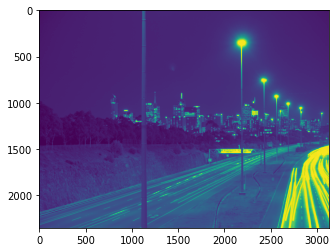

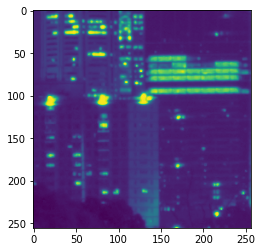

im_node.shape = (4, 4, 4, 4, 4, 4, 4, 4)


In [21]:
file_name = file_list[0]
width=256
height=256
with open(pgmf_path + file_name, 'rb') as pgmf:
  im = plt.imread(pgmf)
  plt.imshow(im)
  plt.show()
  plt.imshow(crop_pgm_image(im, width=width, height=height))
  plt.show()
  im_node, _ = create_node_from_pgm(im, 4, width=width, height=height, transpose_modes=False)
  print(f"im_node.shape = {im_node.shape}")

In [22]:
X = im_node.tensor
X = X.to(torch.float64).to(device)

Без увеличения размерности:


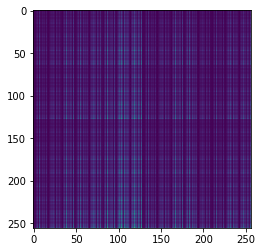

Loss: tensor(4001.5090, device='cuda:0', dtype=torch.float64)
Coef: tensor(0.0005)
Увеличили размерность 5 раз(a):
Loss: tensor(969.5144, device='cuda:0', dtype=torch.float64)
Coef: tensor(0.0016)


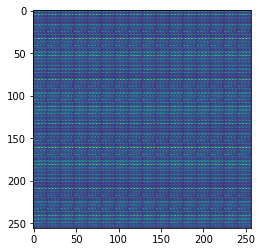

Увеличили размерность 10 раз(a):
Loss: tensor(604.2724, device='cuda:0', dtype=torch.float64)
Coef: tensor(0.0046)


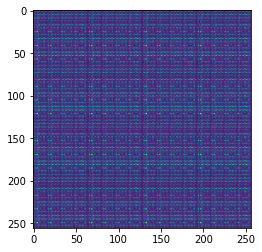

OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB (GPU 0; 4.00 GiB total capacity; 3.31 GiB already allocated; 0 bytes free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [24]:
l = init_nodes()
fit(X, l, num_ep=100, k=6)
Y = make_tensor(l)
print(f'Без увеличения размерности:')
plt.imshow(Y.cpu().detach().numpy().reshape(width, height))
plt.show()
print('Loss:', loss_fn(X, l).data)
print('Coef:', coef(l, height).data)
memory_loss_list = [loss_fn(X, l)]
memory_coef = [coef(l, height)]
i = 0
flag = True
while flag:
    flag = find_best_edge_and_modify_tn(X, l, num_iter_ep = 100, num_itog_ep = 100)
    i += 1
    if i % 5 == 0:
      print(f'Увеличили размерность {i} раз(a):')
      Y = make_tensor(l)
      print('Loss:', loss_fn(X, l).data)
      print('Coef:', coef(l, height).data)
      plt.imshow(Y.cpu().detach().numpy().reshape(width, height))
      plt.show()
      memory_loss_list.append(loss_fn(X, l))
      memory_coef.append(coef(l, height))
    if memory_coef[-1] >= 1.0:
        flag = False

print('Больше ребро не добавится в связи с выбором данного количества итераций.')
print('Итог:')
Y = make_tensor(l)
plt.imshow(Y.detach().numpy().reshape(width, height))
plt.show()
memory_loss_list.append(loss_fn(X, l))
memory_coef.append(coef(l, height))

In [ ]:
print(memory_loss_list)
print(memory_coef)